In [1]:
import pandas as pd
import pathlib as Path
import requests
from dotenv import load_dotenv
import os 
import pyfolio as py
import yfinance as yf
import alpaca_trade_api as tradeapi
import numpy as np
import ta
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from MCForecastTools import MCSimulation
import hvplot.pandas
%matplotlib inline

C:\Users\rrose\anaconda3\envs\dev\Lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
C:\Users\rrose\anaconda3\envs\dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\rrose\anaconda3\envs\dev\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
load_dotenv('env.txt')

True

In [3]:
alpaca_api_key = os.getenv("alpaca_api_key")
secret_alpaca_api_key = os.getenv("alpaca_secret_key")
api = tradeapi.REST(
    alpaca_api_key,
    secret_alpaca_api_key,
    api_version = "v2"
)

In [4]:
tickers = ["KO", "UHN", "PFE", "ABT", "NEE", "DUK", "SO", "PG", "COST", "WMT"]
timeframe= "1Day"
start_date= pd.Timestamp("2018-08-04", tz="America/New_York").isoformat()
end_date= pd.Timestamp("2021-08-04", tz="America/New_York").isoformat()
ticker_data = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

ticker_data.head()

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2018-08-06 04:00:00+00:00,65.24,65.495,64.960,24773,65.09,3995742,65.302687,ABT
2018-08-07 04:00:00+00:00,64.74,65.320,64.730,24392,65.20,3715475,64.866484,ABT
2018-08-08 04:00:00+00:00,64.84,65.310,64.555,31303,64.74,4427847,64.917850,ABT
2018-08-09 04:00:00+00:00,64.64,65.065,64.580,19441,64.79,2858228,64.717558,ABT
2018-08-10 04:00:00+00:00,64.03,64.600,63.870,26771,64.44,4256827,64.161185,ABT


In [5]:
KO = ticker_data[ticker_data["symbol"]=="KO"].drop("symbol", axis=1)
UHN = ticker_data[ticker_data["symbol"]=="UHN"].drop("symbol", axis=1)
PFE = ticker_data[ticker_data["symbol"]=="PFE"].drop("symbol", axis=1)
ABT = ticker_data[ticker_data["symbol"]=="ABT"].drop("symbol", axis=1)
NEE = ticker_data[ticker_data["symbol"]=="NEE"].drop("symbol", axis=1)
DUK = ticker_data[ticker_data["symbol"]=="DUK"].drop("symbol", axis=1)
SO = ticker_data[ticker_data["symbol"]=="SO"].drop("symbol", axis=1)
PG = ticker_data[ticker_data["symbol"]=="PG"].drop("symbol", axis=1)
COST = ticker_data[ticker_data["symbol"]=="COST"].drop("symbol", axis=1)
WMT = ticker_data[ticker_data["symbol"]=="WMT"].drop("symbol", axis=1)

ticker_data = pd.concat([KO, UHN, PFE, ABT, NEE, DUK, SO, PG, COST, WMT], axis=1, keys=["KO", "UHN", "PFE", "ABT", "NEE", "DUK", "SO", "PG", "COST", "WMT"])

ticker_data.head()

KO                                               \
                           close   high      low trade_count   open    volume   
timestamp                                                                       
2018-08-06 04:00:00+00:00  46.65  46.87  46.5500       47166  46.60  11947952   
2018-08-07 04:00:00+00:00  46.50  46.61  46.1300       53647  46.52   9437694   
2018-08-08 04:00:00+00:00  46.15  46.56  46.1226       38903  46.49   7468645   
2018-08-09 04:00:00+00:00  46.35  46.42  46.0750       36925  46.25  11297199   
2018-08-10 04:00:00+00:00  46.08  46.42  45.9650       42689  46.21   8329247   

                                          UHN                    ...    COST  \
                                vwap    close     high      low  ...    open   
timestamp                                                        ...           
2018-08-06 04:00:00+00:00  46.690707  20.3604  20.3690  20.3487  ...  221.43   
2018-08-07 04:00:00+00:00  46.384439  20.5400  20.6000  20.4775  ...  223.24   
2018-08-08 04:00:00+00:00  46.275032  20.5400  20.5400  20.5400  ...  222.86   
2018-08-09 04:00:00+00:00  46.308187  20.0500  20.1861  20.0500  ...  221.62   
2018-08-10 04:00:00+00:00  46.137520  20.0500  20.0500  20.0500  ...  218.14   

                                                  WMT                   \
                            volume        vwap  close     high     low   
timestamp                                                                
2018-08-06 04:00:00+00:00  1564659  222.476888  89.67  89.9812  89.125   
2018-08-07 04:00:00+00:00  1566941  224.065101  89.77  90.3600  89.650   
2018-08-08 04:00:00+00:00  2294138  224.119168  90.05  90.2300  89.370   
2018-08-09 04:00:00+00:00  3810426  218.909183  89.01  89.6300  88.760   
2018-08-10 04:00:00+00:00  3055712  220.338426  90.18  90.3700  88.650   

                                                                  
                          trade_count   open   volume       vwap  
timestamp                                                         
2018-08-06 04:00:00+00:00       38423  89.30  5176961  89.555675  
2018-08-07 04:00:00+00:00       41761  89.78  5143724  89.862872  
2018-08-08 04:00:00+00:00       37611  89.97  5549844  89.942824  
2018-08-09 04:00:00+00:00       39038  89.46  4973690  89.167300  
2018-08-10 04:00:00+00:00       56778  88.70  8973645  90.087501  

[5 rows x 70 columns]

In [6]:
ticker_data_closing = pd.DataFrame()

for ticker in tickers:
    ticker_data_closing[ticker] = ticker_data[ticker]["close"]

ticker_data_closing.index = ticker_data_closing.index.date

ticker_data_closing.head()

,KO,UHN,PFE,ABT,NEE,DUK,SO,PG,COST,WMT
2018-08-06,46.65,20.3604,41.04,65.24,171.01,81.12,48.99,82.52,222.72,89.67
2018-08-07,46.50,20.5400,40.84,64.74,170.63,80.88,49.08,82.64,223.86,89.77
2018-08-08,46.15,20.5400,41.41,64.84,170.08,80.43,46.88,82.35,224.58,90.05
2018-08-09,46.35,20.0500,41.00,64.64,170.85,80.81,46.81,81.40,218.24,89.01
2018-08-10,46.08,20.0500,40.93,64.03,170.93,80.89,46.13,81.43,220.31,90.18


<Axes: >

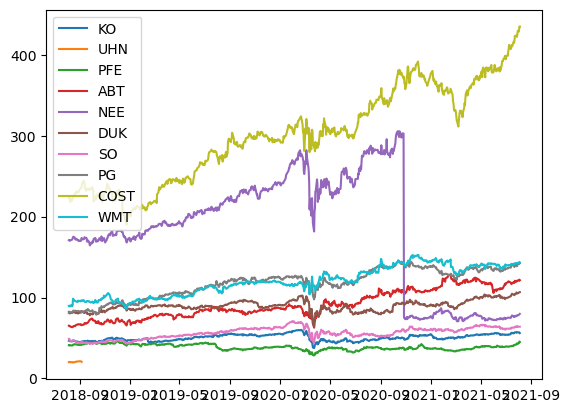

In [7]:
ticker_data_closing.plot()

In [8]:
# 30 day rolling average
ticker_data_closing = ticker_data_closing.rolling(window=30).mean()
# line chat
ticker_data_closing.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [9]:
tickers_1 = ["AMZN", "TSLA", "MCD", "TM", "MSFT", "AAPL", "GOOGL", "JPM", "BAC", "TRST"]
timeframe= "1Day"
start_date_1= pd.Timestamp("2017-01-01", tz="America/New_York").isoformat()
end_date_1= pd.Timestamp("2019-12-31", tz="America/New_York").isoformat()
ticker_data_1 = api.get_bars(
    tickers_1,
    timeframe,
    start=start_date_1,
    end=end_date_1
).df

ticker_data_1.head()

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2017-01-03 05:00:00+00:00,116.15,116.3300,114.76,158508,115.75,31713319,115.655776,AAPL
2017-01-04 05:00:00+00:00,116.02,116.5100,115.75,129948,115.90,23234449,116.120635,AAPL
2017-01-05 05:00:00+00:00,116.61,116.8642,115.81,136223,115.97,23572537,116.458819,AAPL
2017-01-06 05:00:00+00:00,117.91,118.1600,116.47,177799,116.75,33913959,117.732493,AAPL
2017-01-09 05:00:00+00:00,118.99,119.4300,117.94,184632,118.00,36262611,118.969146,AAPL


In [10]:
amzn = ticker_data_1[ticker_data_1["symbol"]=="AMZN"].drop("symbol", axis=1)
tsla = ticker_data_1[ticker_data_1["symbol"]=="TSLA"].drop("symbol", axis=1)
mcd = ticker_data_1[ticker_data_1["symbol"]=="MCD"].drop("symbol", axis=1)
tm = ticker_data_1[ticker_data_1["symbol"]=="TM"].drop("symbol", axis=1)
msft = ticker_data_1[ticker_data_1["symbol"]=="MSFT"].drop("symbol", axis=1)
aapl = ticker_data_1[ticker_data_1["symbol"]=="AAPL"].drop("symbol", axis=1)
googl = ticker_data_1[ticker_data_1["symbol"]=="GOOGL"].drop("symbol", axis=1)
jpm = ticker_data_1[ticker_data_1["symbol"]=="JPM"].drop("symbol", axis=1)
bac = ticker_data_1[ticker_data_1["symbol"]=="BAC"].drop("symbol", axis=1)
trst = ticker_data_1[ticker_data_1["symbol"]=="TRST"].drop("symbol", axis=1)

ticker_data_1 = pd.concat([amzn, tsla, mcd, tm, msft, aapl, googl, jpm, bac, trst], axis=1, keys=["AMZN", "TSLA", "MCD", "TM", "MSFT", "AAPL", "GOOGL", "JPM", "BAC", "TRST"])
                    


In [11]:
ticker_data_closing_1 = pd.DataFrame()

for ticker in tickers_1:
    ticker_data_closing_1[ticker] = ticker_data_1[ticker]["close"]

ticker_data_closing_1.index = ticker_data_closing_1.index.date

expansion_portfolio_returns = ticker_data_closing_1.pct_change()
expansion_portfolio_returns = expansion_portfolio_returns.dropna()
ticker_data_closing_1.head()

,AMZN,TSLA,MCD,TM,MSFT,AAPL,GOOGL,JPM,BAC,TRST
2017-01-03,753.67,216.99,119.62,118.55,62.58,116.15,808.01,87.23,22.53,8.85
2017-01-04,757.18,226.99,119.48,121.19,62.30,116.02,807.77,86.91,22.95,8.95
2017-01-05,780.45,226.75,119.70,120.44,62.30,116.61,813.02,86.11,22.68,8.70
2017-01-06,795.99,229.01,120.76,120.13,62.84,117.91,825.21,86.12,22.68,8.65
2017-01-09,796.92,231.28,120.43,119.74,62.64,118.99,827.18,86.18,22.55,8.50


In [12]:
ticker_data_closing_1.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [13]:
# 30 day rolling average
expansion_portfolio_returns = expansion_portfolio_returns.rolling(window=30).mean()
# line chart
expansion_portfolio_returns.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [14]:
# analysis on stock versus SPDR fund (SPX as benchmark)